## Otimização da Cobrança de Débitos em Serviços Públicos: Estratégias Baseadas em Dados

### Preparação

#### Importação dos dados

In [1]:
from helper import plot_all_cat_freq, remove_outliers, create_stacked_bar_plot,  Pipeline, cv,plot_binary_correlation
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

df = pd.read_parquet('utilities_disconnection.parquet')
df.head()

,client_id,regional,site,client_class,client_subclass,connection_type,connection_status,installment_value,installment_status,total_debt,total_bills,disconnection_date,disconnection_requested,contractor_id,disconnection_executed,collected
0,0,1,13414,1,7,single-phase connection,disconnected,"252,39",complete,"662,62",4,2017-03-06,circuit_break,"66,0",circuit_break,"0,0"
1,1,1,14071,1,1,single-phase connection,disconnected,"0,0",None,"1202,45",17,2017-03-31,circuit_break,"73,0",circuit_break,"0,0"
2,2,1,12380,1,1,biphasic connection,disconnected,"0,0",None,"352,56",1,2017-03-20,circuit_break,"20,0",circuit_break,"0,0"
3,3,1,14071,1,1,biphasic connection,disconnected,"1317,25",complete,"699,23",9,2017-03-29,pole,"73,0",pole,"0,0"
4,4,2,22212,1,1,biphasic connection,disconnected,"2172,29",complete,"484,1",4,2017-03-16,pole,"156,0",circuit_break,"0,0"


### Pré-Processamento

#### Tratamento dos tipos de dados

In [2]:
categorical = [
    'client_id',
    'regional', 
    'site', 
    'client_class', 
    'client_subclass', 
    'connection_type', 
    'connection_status', 
    'installment_status', 
    'disconnection_requested',
    'contractor_id',
    'disconnection_executed'
    ]

numerical = [
    'installment_value',
    'total_debt',
    'total_bills',
    ]

datetime = [
    'disconnection_date'
    ]

target = 'collected'

df[categorical] = df[categorical].astype('object')
for col in numerical:
    df[col] = df[col].astype(str).str.replace(",", ".").astype('float')
df[datetime] = df[datetime].apply(pd.to_datetime)
df[target] = df[target].astype(str).str.replace(",",".").astype('float')
df.head()

,client_id,regional,site,client_class,client_subclass,connection_type,connection_status,installment_value,installment_status,total_debt,total_bills,disconnection_date,disconnection_requested,contractor_id,disconnection_executed,collected
0,0,1,13414,1,7,single-phase connection,disconnected,252.39,complete,662.62,4.0,2017-03-06,circuit_break,"66,0",circuit_break,0.0
1,1,1,14071,1,1,single-phase connection,disconnected,0.00,None,1202.45,17.0,2017-03-31,circuit_break,"73,0",circuit_break,0.0
2,2,1,12380,1,1,biphasic connection,disconnected,0.00,None,352.56,1.0,2017-03-20,circuit_break,"20,0",circuit_break,0.0
3,3,1,14071,1,1,biphasic connection,disconnected,1317.25,complete,699.23,9.0,2017-03-29,pole,"73,0",pole,0.0
4,4,2,22212,1,1,biphasic connection,disconnected,2172.29,complete,484.10,4.0,2017-03-16,pole,"156,0",circuit_break,0.0


#### Tratamento de valores nulos

In [3]:
df.isna().sum()

client_id                       0
regional                        0
site                            0
client_class                    0
client_subclass                 0
connection_type                 0
connection_status               0
installment_value               0
installment_status         370785
total_debt                      0
total_bills                     0
disconnection_date              0
disconnection_requested         0
contractor_id                   0
disconnection_executed          0
collected                       0
dtype: int64

Pela documentação, esses valores faltantes na coluna ``installment_status`` se referem à casos onde não se aplica, então incluiremos essa nova categoria. 

In [4]:
df.fillna('N/A', inplace=True)

#### Linhas repetidas

In [5]:
print(f'Existem {df.shape[0] - df.drop_duplicates().shape[0]} linhas repetidas')

Existem 142 linhas repetidas


In [6]:
df.drop_duplicates(inplace=True)

### Initial Data Analysis

array([[<Axes: title={'center': 'installment_value'}>,
        <Axes: title={'center': 'total_debt'}>,
        <Axes: title={'center': 'total_bills'}>]], dtype=object)

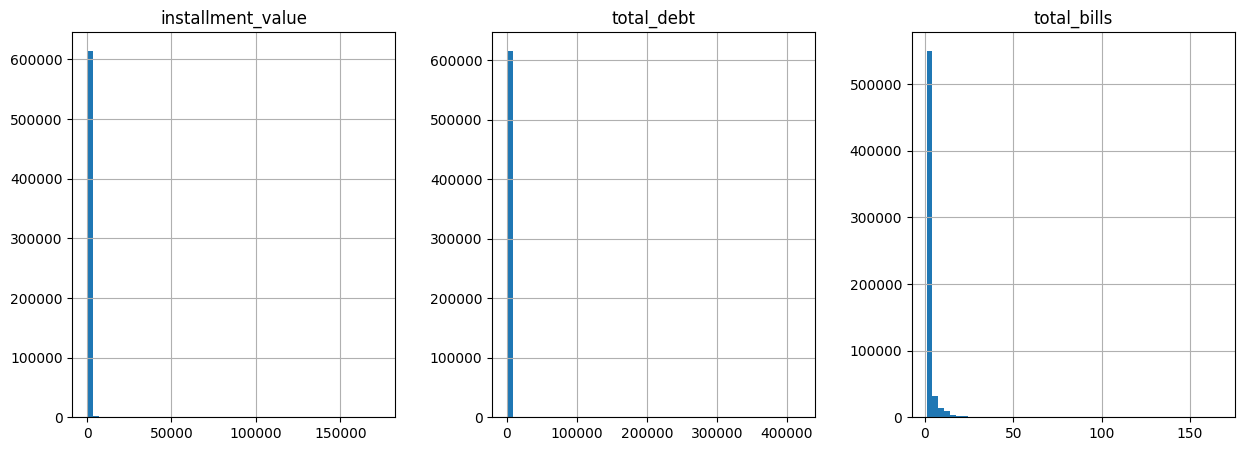

In [7]:
df[numerical].hist(bins = 50, figsize=(15,5),layout = (1,3))

A distribuição das variáveis numéricas é severamente afetada por outliers

array([[<Axes: title={'center': 'installment_value'}>,
        <Axes: title={'center': 'total_debt'}>,
        <Axes: title={'center': 'total_bills'}>]], dtype=object)

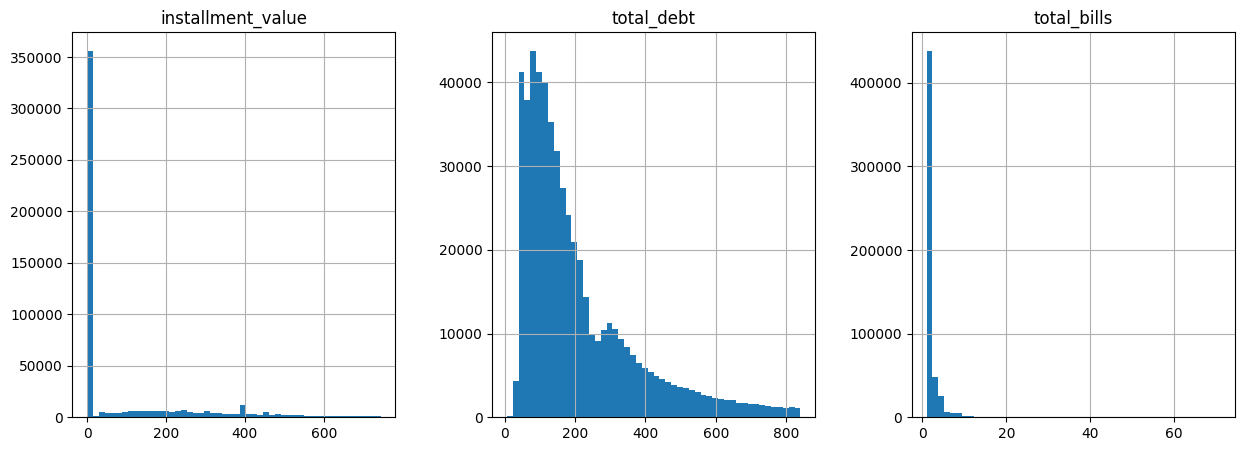

In [8]:
df_filtered = df.loc[df.index.isin(remove_outliers(df[['installment_value', 'total_debt']], bound_const=2))].reset_index(drop=True)
df_filtered[numerical].hist(bins = 50, figsize=(15,5),layout = (1,3))

<Axes: xlabel='total_debt', ylabel='total_bills'>

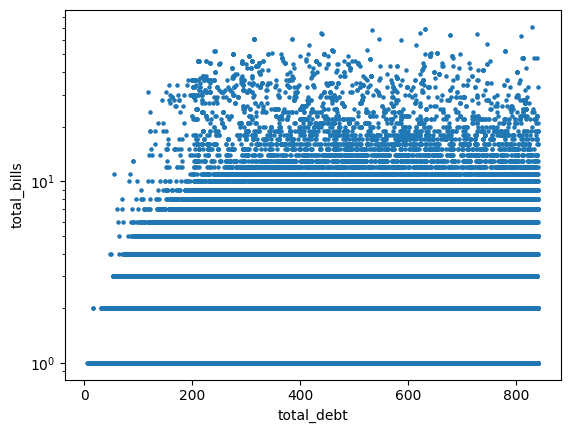

In [9]:
df_filtered.plot(x = 'total_debt', y= 'total_bills', kind = 'scatter', s=5 , logy = True)

Com a remoção de outliers, é possível observar o comportamento dos valores da coluna ``total_debts``, que possui um grande número de registros entre 0 e 250, possuindo um novo pico próximo ao 300 e decaindo a frequência de acordo com o aumento dos valores. 

Tendo essa distribuição em vista, é possível separar os débitos totais em 3 categorias:
- Pequenos débitos: Representam o primeiro pico de distribuição dos débitos, se situando entre 0 e 250
- Médios débitos: Representam a segunda curva, se situando entre 250 e 800
- Altos débitos: Representam valores altos que distoam do comportamento geral dos dados, sendo valores maiores que 800

Pelo segundo gráfico também é possível concluir que para valores baixos do ``total_bills``, existem valores de ``total_debt`` em praticamente todas as faixas, o que significa que existem diferentes valores de contas a serem pagas, se tornando um pouco mais distribuidas (e mais raras) para valores acima de 10.

Com relação à variável ``installment_value`` é possível perceber uma predominância de valores zero, mesmo depois da remoção de outliers.

#### Criando nova coluna com as categorias de total_debt

In [10]:
df['total_debt_class'] = df['total_debt'].apply(lambda x: 'P' if 0 <= x <= 250 else 'M' if 250 < x < 800 else 'G')
categorical.append('total_debt_class')

array([[<Axes: title={'center': 'total_debt'}>]], dtype=object)

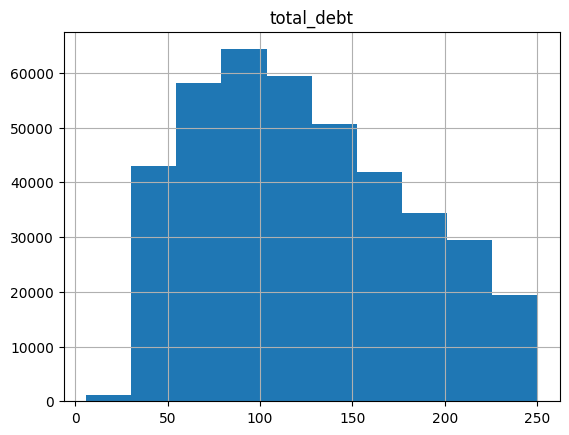

In [11]:
df.loc[df.total_debt_class == 'P',['total_debt']].hist()

array([[<Axes: title={'center': 'total_debt'}>]], dtype=object)

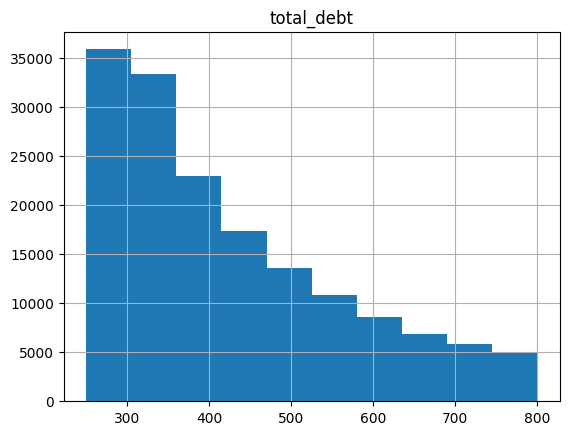

In [12]:
df.loc[df.total_debt_class == 'M',['total_debt']].hist()

array([[<Axes: title={'center': 'total_debt'}>]], dtype=object)

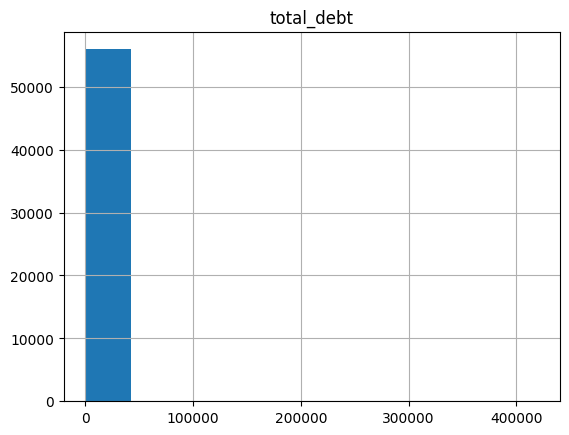

In [13]:
df.loc[df.total_debt_class == 'G',['total_debt']].hist()

#### Explorando variáveis categóricas

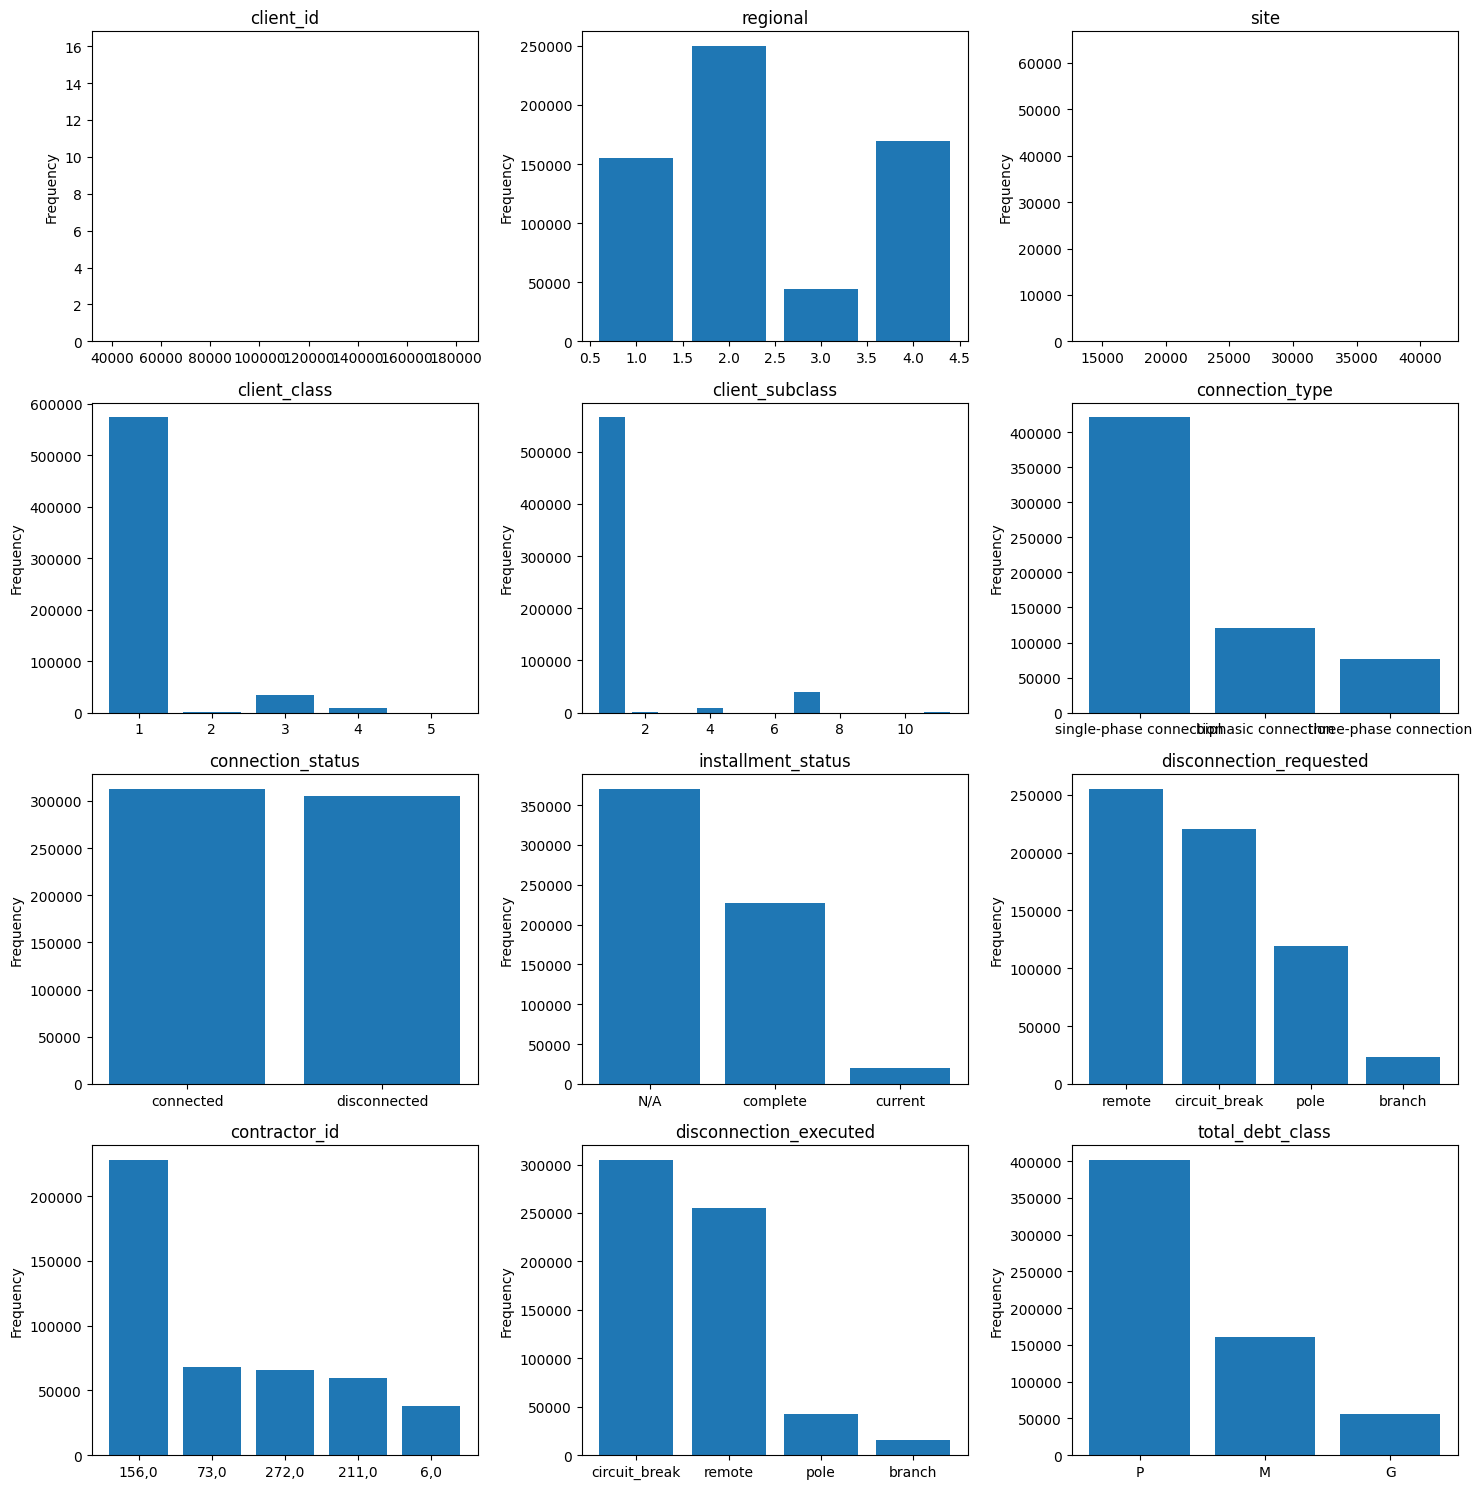

In [14]:
plot_all_cat_freq(df[categorical])

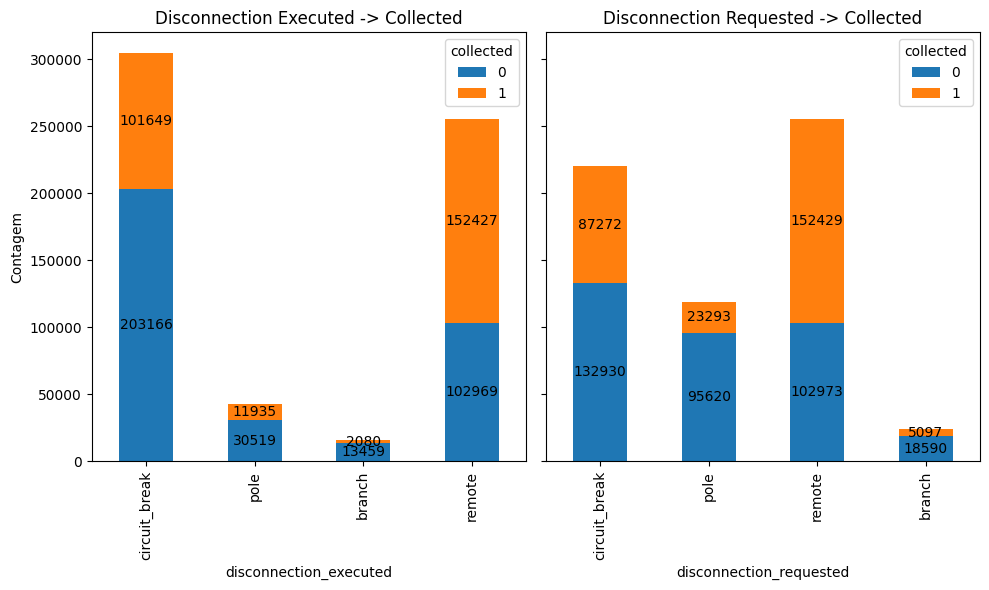

In [15]:
# Creating the subplot
fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

# Plotting each analysis
create_stacked_bar_plot(axs[0], df, 'disconnection_executed', 'collected', "Disconnection Executed -> Collected")
create_stacked_bar_plot(axs[1], df, 'disconnection_requested', 'collected', "Disconnection Requested -> Collected")

plt.tight_layout()
plt.show()

Desconexão de circuito e remotas foram as que possuíram maior taxa de sucesso, sendo a mais eficiente e a desconexão remota.

A desconexão de pole e branch não foram tão frequentes mas muito por serem táticas agressivas e nem sempre se fazem necessárias.

In [16]:
df.loc[:,['disconnection_requested', 'disconnection_executed', 'collected']].groupby(['disconnection_requested', 'disconnection_executed']).agg(['count','mean','sum'])

collected                    
                                                   count      mean       sum
disconnection_requested disconnection_executed                              
branch                  branch                      3332  0.192977     643.0
                        circuit_break              16188  0.206079    3336.0
                        pole                        4166  0.268123    1117.0
                        remote                         1  1.000000       1.0
circuit_break           branch                      2198  0.368517     810.0
                        circuit_break             207222  0.394794   81810.0
                        pole                       10774  0.431316    4647.0
                        remote                         8  0.625000       5.0
pole                    branch                     10009  0.062644     627.0
                        circuit_break              81390  0.202666   16495.0
                        pole                       27512  0.224229    6169.0
                        remote                         2  1.000000       2.0
remote                  circuit_break                 15  0.533333       8.0
                        pole                           2  1.000000       2.0
                        remote                    255385  0.596820  152419.0

- Normalmente as requisições para desconexão remota são realmente executadas
- Resquisições para desconexão de pole e branch nem sempre são executadas, normalmente reduzidas para desconexão de circuito

---

Plotando o percentual de cobranças coletadas em relação a cada uma das categorias que foram utilizadas, incluindo o intervalo de confiança das mesmas.

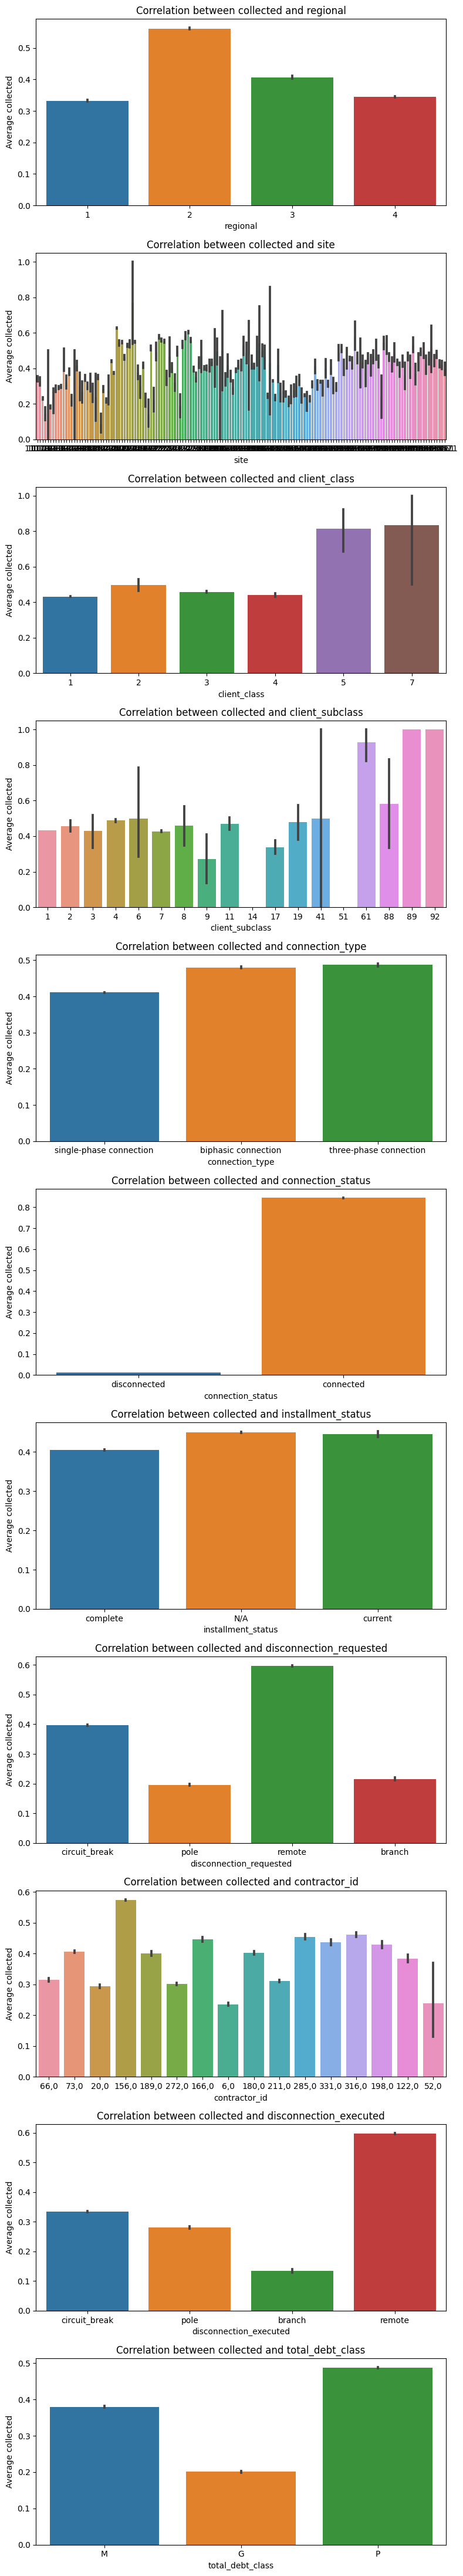

In [17]:
categorical.remove('client_id')
plot_binary_correlation(df[categorical+[target]], target)

- É possível observar que a taxa de sucesso de coleta de cobranças onde o status da conexão é conectado é muito alta e muito baixa para status desconectados.
- Analisando a variável ``total_debt_class`` é possível perceber também que a taxa de sucesso dessa cobrança decai com o aumento do tamanho da dívida.
- A execução da desconexão remota possui uma taxa de sucesso muito maior que as demais, muito provavelmente por serem clientes que já estariam inclinados a pagar, por isso a baixa agressividade.

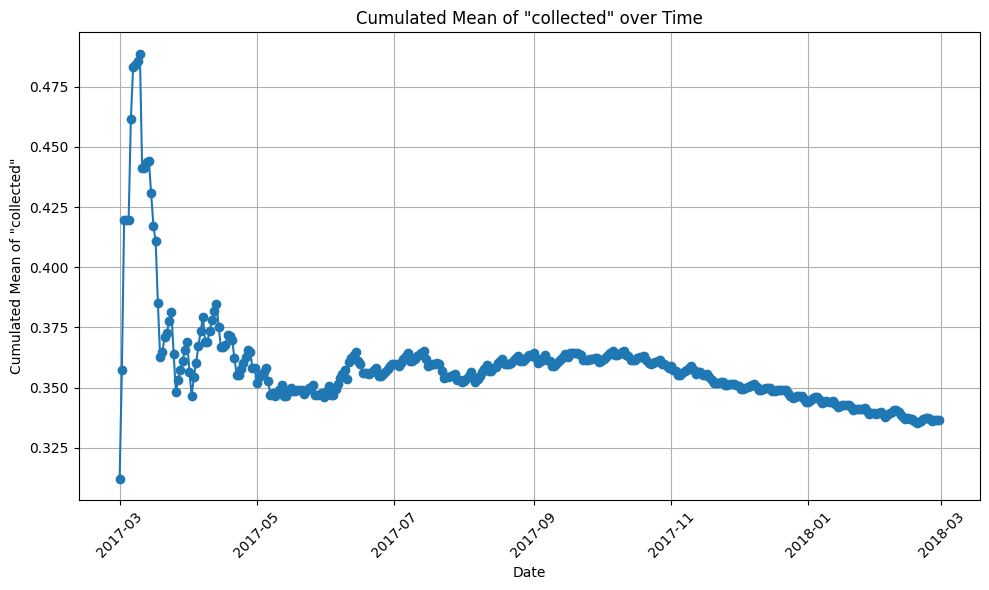

In [18]:
df_date = df.set_index('disconnection_date')

df_daily_mean = df_date[['collected']].resample('D').mean()

df_daily_mean['Cumulative_Mean'] = df_daily_mean['collected'].expanding().mean()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_daily_mean.index, df_daily_mean['Cumulative_Mean'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Cumulated Mean of "collected"')
plt.title('Cumulated Mean of "collected" over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


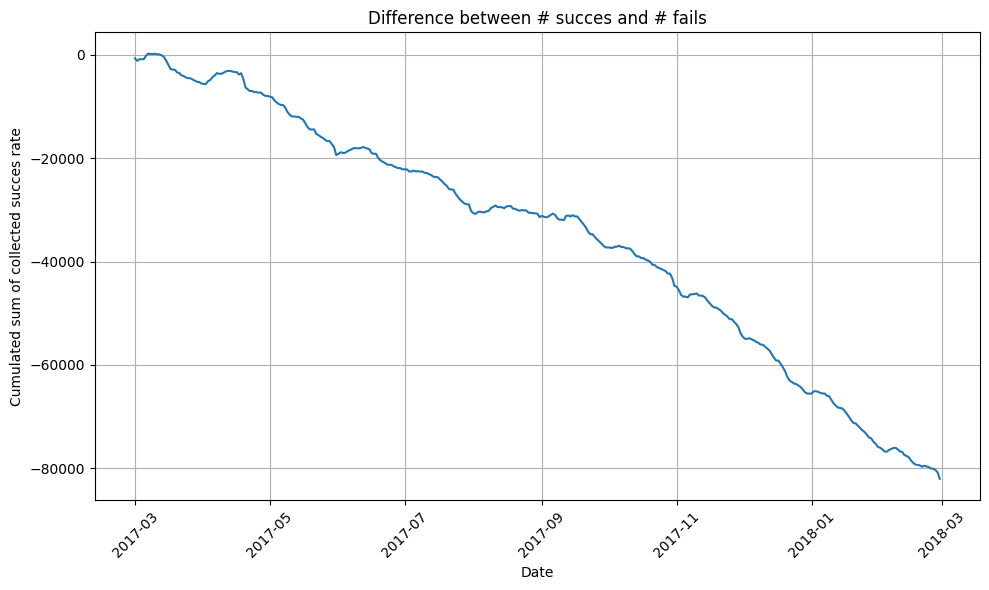

In [22]:
df_date = df.set_index('disconnection_date')
df_date.loc[df_date.collected == 0, ['collected']] = -1

df_daily_sum = df_date[['collected']].resample('D').sum()

df_daily_sum['Cumulative_sum'] = df_daily_sum['collected'].expanding().sum()

plt.figure(figsize=(10, 6))
plt.plot(df_daily_sum.index, df_daily_sum['Cumulative_sum'],linestyle='-')
plt.xlabel('Date')
plt.ylabel('Cumulated sum of collected succes rate')
plt.title('Difference between # succes and # fails')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Durante quase todo o período houve mais falhas na coleta de débito do que sucessos, apesar de existirem pontos de inflexão da curva, trazendo ainda mais importância para esse problema

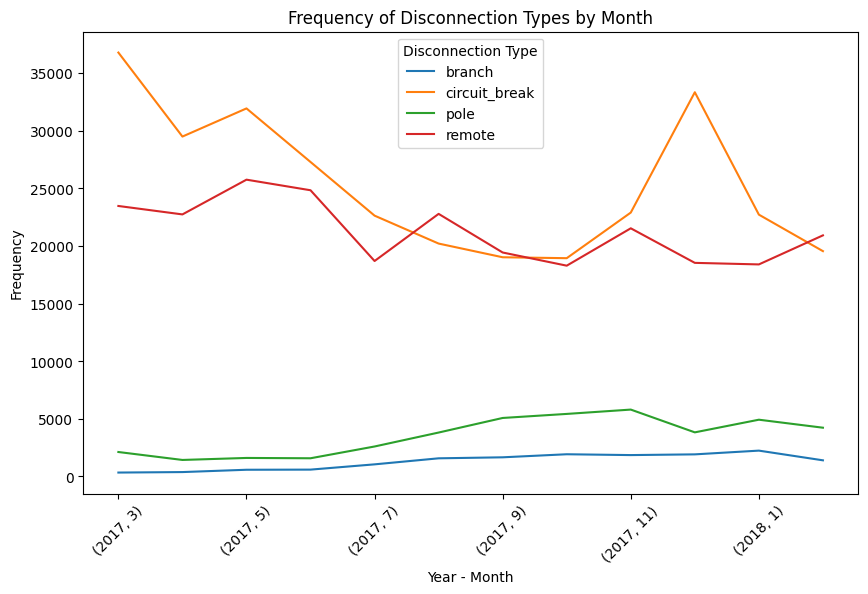

In [31]:
df_pivot = df.loc[:, ['disconnection_executed', 'disconnection_date']]

df_pivot['year'] = df_pivot['disconnection_date'].dt.year
df_pivot['month'] = df_pivot['disconnection_date'].dt.month

freq_data = df_pivot.groupby(['year', 'month', 'disconnection_executed']).size().reset_index(name='frequency')
pivot_data = freq_data.pivot(index=['year', 'month'], columns=['disconnection_executed'], values='frequency').fillna(0)

# Plot the data using a stacked bar plot
pivot_data.plot(kind='line',  figsize=(10, 6))
plt.title('Frequency of Disconnection Types by Month')
plt.xlabel('Year - Month')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend(title='Disconnection Type')
plt.show()

O número de desconexões pole e de branch teve um leve aumento ao longo dos meses, a frequência de desconexões remotas não obteve muita variação, podendo indicar uma saturação do serviço (hipótese), e o número de execuções de circuit_break possuiu picos de frequência em momentos diferentes.

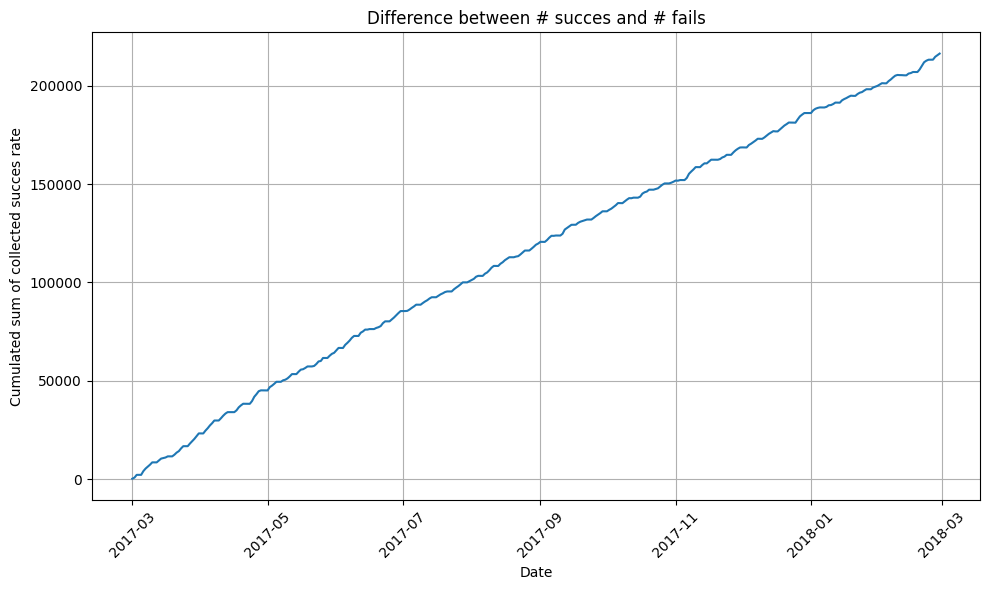

In [32]:
df_date = df.set_index('disconnection_date')

df_date = df_date.loc[df_date.connection_status == 'connected']
df_date.loc[df_date.collected == 0, ['collected']] = -1

df_daily_sum = df_date[['collected']].resample('D').sum()
df_daily_sum['Cumulative_sum'] = df_daily_sum['collected'].expanding().sum()

plt.figure(figsize=(10, 6))
plt.plot(df_daily_sum.index, df_daily_sum['Cumulative_sum'],linestyle='-')
plt.xlabel('Date')
plt.ylabel('Cumulated sum of collected succes rate')
plt.title('Difference between # succes and # fails')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Quando analisamos a taxa de sucesso quando a conexão está habilitada no momento da cobrança é possível ver o claro aumento contínuo do número de sucessos, reforçando ainda mais que é uma característica forte em comparação com a coleta do débito ou não

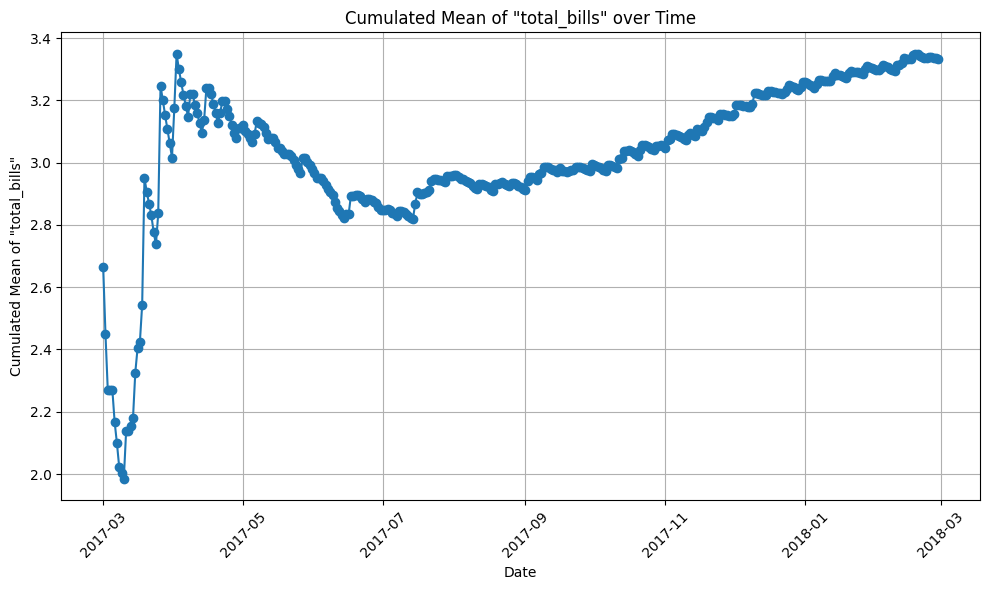

In [35]:
df_date = df.set_index('disconnection_date')

df_daily_mean = df_date[['total_bills']].resample('D').mean()
df_daily_mean['Cumulative_Mean'] = df_daily_mean['total_bills'].expanding().mean()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_daily_mean.index, df_daily_mean['Cumulative_Mean'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Cumulated Mean of "total_bills"')
plt.title('Cumulated Mean of "total_bills" over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


A média diária do total de contas a pagar de clientes que sofrem desconexão no dia é de aproximadamente 3, o que indica que clientes que chegam a esse ponto da desconexão tendem a deixar contas acumularem, o que pode ser, também, uma das causas da baixa taxa de sucesso na coleta.

## Feature Engineering
De acordo com a exploração, observa-se que no dataframe existem clientes que possuem mais de uma desconexão, e acredito que a recorrência de pagamento possui um impacto grande na hora de decidir se o determinado cliente irá efetuar o pagamento.

Vamos criar as variáveis ``num_disconnection_until_now`` e ``num_collected_until_now``

In [36]:
df.sort_values(by='disconnection_date', inplace=True)

hash_client = {}
num_disconnection_until_now = []
num_collected_until_now = []
for index, row in df.iterrows():
    if row['client_id'] not in hash_client:
        num_disconnection_until_now.append(0)
        num_collected_until_now.append(0)
        hash_client[row['client_id']] = [1,row['collected']]
    else:
        num_disconnection_until_now.append(hash_client[row['client_id']][0])
        num_collected_until_now.append(hash_client[row['client_id']][1])
        hash_client[row['client_id']][0] += 1
        hash_client[row['client_id']][1] += row['collected']


In [37]:
df['num_disconnection_until_now'] = num_disconnection_until_now
df['num_collected_until_now'] = num_collected_until_now

In [38]:
df.loc[:,['num_collected_until_now', 'num_disconnection_until_now']].describe()

,num_collected_until_now,num_disconnection_until_now
count,618204.000000,618204.000000
mean,0.234356,0.569238
std,0.673306,1.116050
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,1.000000
max,11.000000,15.000000


In [39]:
df.loc[df.client_id == 2038]

,client_id,regional,site,client_class,client_subclass,connection_type,connection_status,installment_value,installment_status,total_debt,total_bills,disconnection_date,disconnection_requested,contractor_id,disconnection_executed,collected,total_debt_class,num_disconnection_until_now,num_collected_until_now
1416,2038,1,12390,1,1,single-phase connection,disconnected,0.0,N/A,127.59,1.0,2017-03-01,circuit_break,"20,0",circuit_break,1.0,P,0,0.0
39635,2038,1,12390,1,1,single-phase connection,disconnected,0.0,N/A,127.59,1.0,2017-03-21,circuit_break,"20,0",circuit_break,0.0,P,1,1.0


Dúvida: total_debt se manteve mesmo depois do pagamento em 01/03

In [40]:
df.loc[df.client_id == 526963]

,client_id,regional,site,client_class,client_subclass,connection_type,connection_status,installment_value,installment_status,total_debt,total_bills,disconnection_date,disconnection_requested,contractor_id,disconnection_executed,collected,total_debt_class,num_disconnection_until_now,num_collected_until_now
308660,526963,2,21025,1,1,biphasic connection,connected,656.17,complete,42.44,1.0,2017-08-21,remote,"156,0",remote,1.0,P,0,0.0
415533,526963,2,21025,1,1,biphasic connection,connected,656.17,complete,49.17,1.0,2017-11-01,remote,"156,0",remote,1.0,P,1,1.0
527893,526963,2,21025,1,1,biphasic connection,connected,656.17,complete,88.76,1.0,2018-01-03,remote,"156,0",remote,1.0,P,2,2.0
616451,526963,2,21025,1,1,biphasic connection,connected,656.17,complete,193.01,1.0,2018-02-28,remote,"156,0",remote,1.0,P,3,3.0


Aqui se mostra um pouco melhor distribuído

array([[<Axes: title={'center': 'num_disconnection_until_now'}>,
        <Axes: title={'center': 'num_collected_until_now'}>]],
      dtype=object)

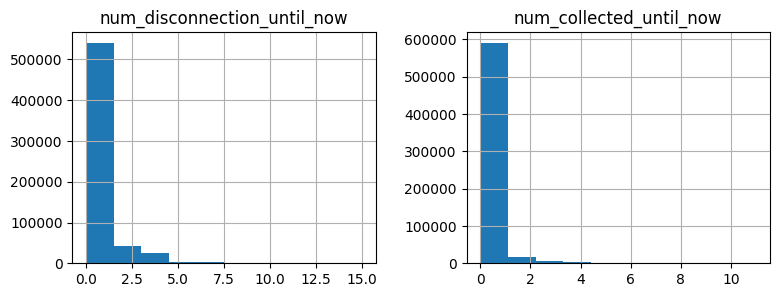

In [48]:
df.loc[:,['num_disconnection_until_now', 'num_collected_until_now']].hist(figsize=(9,3))

As duas novas features possuem muitos valores 0 devido à quantidade de clientes distintos da base, mas auxiliam a ter uma noção melhor sobre o histórico de pagamento daquele cliente

-----------

#### Escolha de variáveis importantes para a análise da causa raiz

O objetivo do projeto é tornar a metodologia de seleção do pedido de desconexão eficiente, dessa maneira, podemos separar em duas frentes:

- Aumentar a taxa de sucesso de coleta do débito
- Reduzir gastos sem queda de performance da coleta de débito

Dessa maneira, podemos elencar 3 grandes grupos de características que podem influenciar na decisão de pagamento do cliente:
- Características presentes do cliente e do seu produto
    - ``client_class``: Essa variável pode auxiliar a trazer características do perfil de cliente
    - ``regional``: Também voltada para o perfil do cliente, uma das categorias possui uma taxa de sucesso acima do normal, o que pode ser um bom indício de que ela consegue diferenciar positivos e negativos de maneira eficiente.
    - ``connection_status``: Essa categoria se mostrou extremamente relevante, uma vez que possui duas categorias com comportamentos muito distintos, uma com uma taxa muito alta de sucesso e outra com uma taxa muito baixa. Parece ser uma característica essencial.
- Dimensão do pagamento
    - ``total_debts``: Essa variável possui um impacto direto na decisão de pagamento do cliente
    - ``total_debt_class``: Classificação do tamanho do débito do cliente até então
    - ``total_bills``: Essa variável traz à tona a reincidência do cliente, o que pode indicar uma característica do histórico de pagamento do cliente
    - ``num_collected_until_now``: 
    - ``num_disconnection_until_now``:
- Ação de cobrança executada
    - ``disconnection_executed``: Essa variável indica a ação executada, que interfere tanto no gasto pela empresa quando na agressividade recebida pelo cliente


Dentre essas variáveis, selecionaremos ainda quais serão mais relevantes do ponto de vista do modelo.

### Feature selection

Com o objetivo de prevenir o vazamento de dados e garantir proximidade com o mundo real, a divisão da base é feita antes de todas análises referentes ao modelo.

Como o modelo possui um vínculo temporal, então a base completa será dividida em treino, teste e validação.
- Os dados de treinos serão as informações disponíveis para o modelo executar seu treinamento.
- Os dados de teste serão as informações utilizadas para comparação de métricas de desempenho do modelo.
- Os dados de validação serão as métricas finais do projeto, simulando a previsão para novos dados.

Será feita a divisão de 70% da base para treino, 20% para teste e 10% para validação, sendo essa base de validação composta pelos registros mais recentes.

In [21]:
categorical = [
    'regional', 
    'client_class',
    'connection_status',
    'disconnection_executed'
]
numerical = [
    'total_debt',
    'total_bills'
]
datetime = [
    'disconnection_date'
]
target= 'collected'

pipeline_01 = Pipeline(df, categorical, numerical, 'collected')
pipeline_01.preprocessing()

#### Seleção do modelo de machine learning

Para selecionar o modelo a ser utilizado, precisa-se ter em mente que é um modelo de classificação binária, uma vez que a variável objetivo possui apenas duas categorias. Para isso, selecionei 7 modelos para uma busca por seus hiperparâmetros. Baseado no que foi visto até então, modelos que são robustos a outliers e que performam bem com variáveis categóricas e numéricas tendem a obter uma melhor performance

In [ ]:
mlflow.set_experiment('Model Selection')

# Define the parameter grid for each model
param_grid = {
    'LogisticRegression': {
        'C': [0.001, 0.01, 0.05, 0.1, 1.0, 10.0]
    },
    'RandomForestClassifier': {
        'n_estimators': [200, 500],
        'max_depth': [None, 20, 30]
    },
    'DecisionTreeClassifier': {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20]
    },
    'RidgeClassifier': {
        'alpha': [0.1, 1.0, 10.0],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'saga']
    },
    'AdaBoostClassifier': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.5, 1.0]
    },
    'MLPClassifier': {
        'hidden_layer_sizes': [(100,), (50, 50), (100, 50, 25)],
        'activation': ['relu', 'tanh'],
    },
    'LinearSVC': {
        'C': [0.1, 1.0, 10.0],
        'max_iter': [1000, 2000, 5000]
    }
}

models = [RandomForestClassifier, LogisticRegression, DecisionTreeClassifier, RidgeClassifier, AdaBoostClassifier, MLPClassifier, LinearSVC]

for model in models:
    model_name = model.__name__
    param_grid_model = param_grid[model_name]

    with mlflow.start_run():
        clf = model()
        grid_search = GridSearchCV(clf, param_grid_model, n_jobs=-1, scoring='precision', refit=True)
        grid_search.fit(pipeline_01.X_processed, pipeline_01.y_processed)
        predict = grid_search.predict(pipeline_01.X_processed_test)
        f1 = f1_score(pipeline_01.y_processed_test, predict)
        prec = precision_score(pipeline_01.y_processed_test, predict)
        rec = recall_score(pipeline_01.y_processed_test, predict)
        acc = accuracy_score(pipeline_01.y_processed_test, predict)
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_param("model", model_name)
        mlflow.log_metric("f1", f1)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", rec)
        mlflow.log_metric("accuracy", acc)


![image.png](images\model_selection.PNG)

Como esperado, todos os resultados foram muito próximos uns dos outros, o que leva a crer que existe uma correlação muito forte com a variável ``connection_status``

In [23]:
model = LogisticRegression(
            random_state=42,
            max_iter=500,
            C=0.1,
        )
num_folds = 5
cv_Precision = cv(pipeline_01.X_processed.values, pipeline_01.y_processed.values,  model, num_folds, metric=precision_score)
print(f'5-Fold Cross Validation Precision: {cv_Precision}')

model.fit(pipeline_01.X_processed.values, pipeline_01.y_processed.values.ravel())
y_pred = model.predict(pipeline_01.X_processed_test.values)
test_Precision= precision_score(pipeline_01.y_processed_test.values,y_pred)
print(f'Test Set Precision: {test_Precision:.4f}')


5-Fold Cross Validation Precision: [0.8436943315214909, 0.8441434912582662, 0.8441673279673506, 0.8462044856079179, 0.8451317400571403]
Test Set Precision: 0.8424


In [24]:
(pipeline_01.X_processed_test.connection_status_connected.values == y_pred).sum()/len(y_pred)

0.9991426792083532

A previsão do modelo está quase 100% ligada à variável ``connection_status``

Vamos desenvolver um algoritmo simples para tentar trazer alguma feature importance para o modelo com todas as variáveis sem o connection_status

In [90]:
categorical = [
    'regional', 
    'client_class',
    'disconnection_executed',
    'total_debt_class'
]
numerical = [
    'total_debt',
    'total_bills',
    'num_collected_until_now',
    'num_disconnection_until_now'
]
datetime = [
    'disconnection_date'
]
target= 'collected'

teste_features = Pipeline(df, categorical, numerical, 'collected')
teste_features.preprocessing()

In [92]:
model = RandomForestClassifier(random_state=42, n_estimators=200)
model.fit(teste_features.X_processed.values, teste_features.y_processed.values.ravel())
fi = {x:y for x,y in zip(teste_features.X_processed.columns, model.feature_importances_)}
sorted_fi = {k: v for k, v in sorted(fi.items(), key=lambda item: item[1], reverse=True)}
sorted_fi

{'total_debt': 0.5926202301785344,
 'total_bills': 0.17329435971680765,
 'num_disconnection_until_now': 0.05337893596008732,
 'disconnection_executed_remote': 0.05153864044950355,
 'num_collected_until_now': 0.047737223010265194,
 'regional_2': 0.020110573090398338,
 'disconnection_executed_circuit_break': 0.01775556110208627,
 'total_debt_class_P': 0.008182958839649592,
 'total_debt_class_G': 0.007316113247626727,
 'regional_1': 0.005653766527012395,
 'disconnection_executed_branch': 0.00422303332833224,
 'regional_4': 0.004134583780561647,
 'disconnection_executed_pole': 0.003545059383706371,
 'client_class_1': 0.002348447645961883,
 'regional_3': 0.002251197398514984,
 'total_debt_class_M': 0.0022431864250312093,
 'client_class_3': 0.001959468304002165,
 'client_class_4': 0.0012203195248536775,
 'client_class_2': 0.0004194951653974806,
 'client_class_5': 3.7038025722198006e-05,
 'client_class_7': 2.9808895944812596e-05}

Ao contrário da hipótese inicial, percebe-se que a variável client_class exerce uma influência muito menor no resultado da previsão

Baseado no resultado anterior, selecionaremos as variáveis:
- ``total_debt``
- ``total_bills``
- ``num_disconnection_until_now``
- ``num_collected_until_now``
- ``disconnection_executed``
- ``regional``

Mostrando que características relacionadas à conta do cliente possuem muito mais impacto na decisão

In [93]:
categorical = ['regional',
    'disconnection_executed'
]
numerical = [
    'total_debt',
    'total_bills',
    'num_collected_until_now',
    'num_disconnection_until_now'
]
target= 'collected'

pipeline_02 = Pipeline(df, categorical, numerical, 'collected')
pipeline_02.preprocessing()

Executando o gridsearch para a otimização dos hiperparametros (poderia ser mais extensiva com mais recursos e tempo disponível)

In [ ]:
mlflow.set_experiment('Model Selection_v4')

# Define the parameter grid for each model
param_grid = {
    'LogisticRegression': {
        'C': [0.001, 0.01, 0.05, 0.1, 1.0, 10.0],
        'penalty': ['l1', 'l2'],
    },
    'RandomForestClassifier': {
        'n_estimators': [200],
        'max_depth': [None, 30],
        'min_samples_split': [2, 10],
        'min_samples_leaf': [1, 5],
        'max_features': ['auto','sqrt']
    },
    'DecisionTreeClassifier': {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 20],
        'min_samples_split': [2, 10],
        'min_samples_leaf': [1, 4],
        'max_features': ['auto', 'sqrt']
    },
    'RidgeClassifier': {
        'alpha': [0.01, 0.1, 1.0, 10.0],
        'fit_intercept': [True, False]
    },
    'AdaBoostClassifier': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.5, 1.0],
        'algorithm': ['SAMME', 'SAMME.R']
    },
    'LinearSVC': {
        'C': [0.1, 1.0, 10.0],
        'max_iter': [1000, 2000, 5000],
        'penalty': ['l1', 'l2']
    }
}

models = [RandomForestClassifier, LogisticRegression, DecisionTreeClassifier, RidgeClassifier, AdaBoostClassifier, LinearSVC]

for model in models:
    model_name = model.__name__
    param_grid_model = param_grid[model_name]

    with mlflow.start_run():
        clf = model()
        grid_search = GridSearchCV(clf, param_grid_model, scoring='precision', refit=True, n_jobs=-1, verbose = 5)
        grid_search.fit(pipeline_02.X_processed, pipeline_02.y_processed.values.ravel())
        predict = grid_search.predict(pipeline_02.X_processed_test)
        f1 = f1_score(pipeline_02.y_processed_test, predict)
        prec = precision_score(pipeline_02.y_processed_test, predict)
        rec = recall_score(pipeline_02.y_processed_test, predict)
        acc = accuracy_score(pipeline_02.y_processed_test, predict)
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_param("model", model_name)
        mlflow.log_metric("f1", f1)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", rec)
        mlflow.log_metric("accuracy", acc)


![image.png](images\model_selection2.PNG)

Dentre os modelos selecionados, DecisionTreeClassifier e RandomForestClassifier obtiveram as melhores performances.

DecisionTreeClassifier:

Prós:

- Fácil de entender e interpretar, pois representa uma estrutura em forma de árvore.
- Requer menos pré-processamento dos dados.

Contras:

- Tendem a ter overfitting.
- São sensíveis a pequenas variações nos dados de treinamento.

RandomForestClassifier:

Prós:

- Reduz o overfitting, agregando as previsões de várias árvores.
- Melhora a precisão geral em comparação com uma única árvore de decisão.
- Pode lidar com um grande número de atributos e é menos sensível a pequenas variações nos dados.

Contras:

- Pode ser mais difícil de interpretar do que uma única árvore de decisão.
- Pode ser computacionalmente mais custoso de treinar e prever, especialmente em grandes conjuntos de dados.

Vamos utilizar os dois modelos para uma validação cruzada e entender se possuem uma boa capacidade de generalização

In [95]:
modelo_dt = DecisionTreeClassifier(
    random_state=42,
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=10,
    criterion='entropy'
)
modelo_rf = RandomForestClassifier(
    random_state=42,
    n_estimators=500,
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=10
)

Modelo da Decision Tree

In [96]:
num_folds = 5
cv_f1 = cv(pipeline_02.X_processed.values, pipeline_02.y_processed.values,  modelo_dt, num_folds, metric=f1_score)
print(f'5-Fold Cross Validation F1-Score: {cv_f1}')

modelo_dt.fit(pipeline_02.X_processed.values, pipeline_02.y_processed)
y_pred = modelo_dt.predict(pipeline_02.X_processed_test.values)
test_f1= f1_score(pipeline_02.y_processed_test.values,y_pred)
print(f'Test Set F1-Score: {test_f1:.4f}')

5-Fold Cross Validation F1-Score: [0.6903386014992225, 0.6825634801646795, 0.6783965654470467, 0.6887361481273672, 0.6860122207280535]
Test Set F1-Score: 0.6874


Modelo da Random Forest

In [97]:
num_folds = 5
cv_f1 = cv(pipeline_02.X_processed.values, pipeline_02.y_processed.values,  modelo_rf, num_folds, metric=f1_score)
print(f'5-Fold Cross Validation F1-Score: {cv_f1}')

modelo_rf.fit(pipeline_02.X_processed.values, pipeline_02.y_processed)
y_pred = modelo_rf.predict(pipeline_02.X_processed_test.values)
test_f1= f1_score(pipeline_02.y_processed_test.values,y_pred)
print(f'Test Set F1-Score: {test_f1:.4f}')

5-Fold Cross Validation F1-Score: [0.6720911514663717, 0.6800843902088178, 0.6807209488432091, 0.681475840898545, 0.6821217324937988]


c:\Users\leonardodomingos\.virtualenvs\LeonardoDomingosKearney-Q09UpS7u\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Test Set F1-Score: 0.6814


Em ambos métodos os resultados obtidos na validação cruzada se mostraram próximos do comportamento geral da base de treino, mostrando que, aparentemente, não houve overfit em nenhum dos casos.

#### Scores

Precision:

A precisão mede a proporção de verdadeiros positivos em relação ao total de instâncias classificadas como positivas. Em outras palavras, ela indica a capacidade do modelo de acertar quando prevê uma classe como positiva. A fórmula é: Precision = True Positives / (True Positives + False Positives).

Recall:

O recall, também conhecido como sensibilidade ou taxa de verdadeiros positivos, mede a proporção de instâncias positivas corretamente identificadas pelo modelo em relação ao total de instâncias realmente positivas. Em termos simples, é a capacidade do modelo de encontrar todas as instâncias relevantes. A fórmula é: Recall = True Positives / (True Positives + False Negatives).

F1-score:

O F1-score é uma métrica que combina a precisão e o recall para fornecer um equilíbrio entre as duas medidas. Ele é útil quando temos um desequilíbrio de classes, pois leva em conta tanto os falsos positivos quanto os falsos negativos. Quanto mais próximo de 1, melhor é o desempenho do modelo em termos de precisão e recall. A fórmula é: F1-Score = 2 * (Precision * Recall) / (Precision + Recall).

Acurácia:

A acurácia é a medida mais comum e simples, representando a proporção de predições corretas em relação ao total de predições feitas pelo modelo. Ela é útil quando todas as classes têm importância semelhante e o conjunto de dados está bem equilibrado. A fórmula é: Accuracy = (True Positives + True Negatives) / Total.

<img src="images\Precisão_e_revocação.png" alt="Descrição da imagem" width="300" height="600" />

Opta-se pelo uso do <font color="red">precision</font> como referência para definição da qualidade do modelo, uma vez que ela aumenta com a diminuição dos Falsos Positivos, que seriam os casos onde o modelo entende que o cliente pagaria o débito mas na realidade ele não pagaria. 

In [98]:
num_folds = 5
cv_precision = cv(pipeline_02.X_processed.values, pipeline_02.y_processed.values,  modelo_dt, num_folds, metric=precision_score)
print(f'5-Fold Cross Validation Precision: {cv_precision}')

modelo_dt.fit(pipeline_02.X_processed.values, pipeline_02.y_processed)
y_pred = modelo_dt.predict(pipeline_02.X_processed_test.values)
test_precision= precision_score(pipeline_02.y_processed_test.values,y_pred)
print(f'Test Set Precision: {test_precision:.4f}')

5-Fold Cross Validation Precision: [0.6123852266644707, 0.6191740604019601, 0.6220723211323675, 0.6170667336936031, 0.6189442315879098]
Test Set Precision: 0.6179


In [100]:
cv_precision = cv(pipeline_02.X_processed.values, pipeline_02.y_processed.values,  modelo_rf, num_folds, metric=precision_score)
print(f'5-Fold Cross Validation Precision: {cv_precision}')

5-Fold Cross Validation Precision: [0.6375501049818668, 0.6206813557096909, 0.6192628650904033, 0.6193205164248178, 0.6209022621683817]
Test Set Precision: 0.6179


In [102]:
y_pred = modelo_rf.predict(pipeline_02.X_processed_test.values)
test_precision = precision_score(pipeline_02.y_processed_test.values,y_pred)
print(f'Test Set Precision: {test_precision:.4f}')

Test Set Precision: 0.6202


Mais uma vez os resultados da validação cruzada se mostram próximos ao do dataset de teste, indicando que não ouve overfit.

Como última validação, vamos testar alguns modelos dummy para garantir que o programa realmente aprendeu com as variáveis que foram passadas:

In [104]:
for strategy in ['most_frequent', 'prior', 'stratified', 'uniform', 'constant']:
    dummy_clf = DummyClassifier(strategy = strategy, constant=1)
    dummy_clf.fit(pipeline_02.X_processed.values, pipeline_02.y_processed)
    y_pred_dummy = dummy_clf.predict(pipeline_02.X_processed_test.values)
    print(f'Utilizando a estratégia {strategy}: Prec = {precision_score(pipeline_02.y_processed_test,y_pred_dummy):.2f}')

c:\Users\leonardodomingos\.virtualenvs\LeonardoDomingosKearney-Q09UpS7u\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\leonardodomingos\.virtualenvs\LeonardoDomingosKearney-Q09UpS7u\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Utilizando a estratégia most_frequent: Prec = 0.00
Utilizando a estratégia prior: Prec = 0.00
Utilizando a estratégia stratified: Prec = 0.44
Utilizando a estratégia uniform: Prec = 0.44
Utilizando a estratégia constant: Prec = 0.44


Dessa forma, houve um ganho de precision de aproximadamente 40%

Vamos testar um modelo de votação que englobe os dois modelos e ver o comportamento

In [44]:
eclf = VotingClassifier( estimators=[('dt', DecisionTreeClassifier(
    random_state=42,
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=10,
    criterion='entropy'
)), ('rf', RandomForestClassifier(
    random_state=42,
    n_estimators=500,
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=10
))], voting='soft', n_jobs = -1)

cv_precision = cv(pipeline_02.X_processed.values, pipeline_02.y_processed.values,  eclf, num_folds, metric=precision_score)
print(f'5-Fold Cross Validation Precision: {cv_precision}')

modelo_rf.fit(pipeline_02.X_processed.values, pipeline_02.y_processed)
y_pred = modelo_rf.predict(pipeline_02.X_processed_test.values)
test_precision = precision_score(pipeline_02.y_processed_test.values,y_pred)
print(f'Test Set Precision: {test_precision:.4f}')

5-Fold Cross Validation Precision: [0.6183429803104793, 0.6145196828930332, 0.6120364302018124, 0.6144043663977219, 0.6157473531478836]


c:\Users\leonardodomingos\.virtualenvs\LeonardoDomingosKearney-Q09UpS7u\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Test Set Precision: 0.6100


Não apresentou melhoras significativas

### Gerando previsões

Vamos utilizar o modelo DecisionTreeForest que performa igualmente e é muito menor que o modelo de Random Forest, viabilizando um possível uso em produção da empresa.

Para realizar a previsão, vamos utilizar o dataset de validação que contempla os registros mais recentes desse dataset, que traz uma noção de como ele se comportaria com dados reais e não vistos pelo modelo em nenhuma etapa.

In [105]:
modelo_dt = DecisionTreeClassifier(
    random_state=42,
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=10,
    criterion='entropy'
)
pipeline_03 = Pipeline(df, categorical, numerical, 'collected')
pipeline_03.preprocessing()
pipeline_03.df_val

df_val = pipeline_03.df_val.loc[:,pipeline_03.categorical+pipeline_03.numerical+[pipeline_03.target]]
X = df_val.drop([target], axis = 1)
y = df_val[[target]]

X_categorical_val = pd.DataFrame(pipeline_03.cat_encoder.transform(X[pipeline_03.categorical]), columns=pipeline_03.cat_encoder.get_feature_names_out())
X_numeric_normalized_val = pd.DataFrame(pipeline_03.num_normalizer.transform(X[pipeline_03.numerical]), columns=pipeline_03.numerical)
X_processed_val = pd.concat([X_categorical_val, X_numeric_normalized_val], axis=1)

modelo_dt.fit(pipeline_03.X_processed.values, pipeline_03.y_processed)
y_pred = modelo_dt.predict(X_processed_val.values)

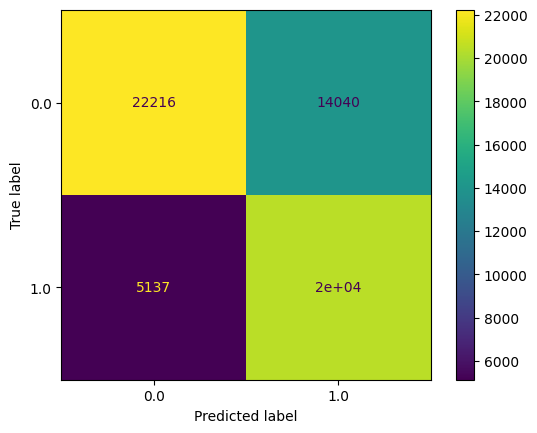

In [106]:
cm = confusion_matrix(y.values.ravel(), y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=modelo_dt.classes_)
disp.plot()

In [107]:
prec = precision_score(y.values.ravel(), y_pred)
acc = accuracy_score(y.values.ravel(), y_pred)
rec = recall_score(y.values.ravel(), y_pred)
f1 = f1_score(y.values.ravel(), y_pred)
print(f'''O resultado obtido para a métrica principal (precision) foi de: {prec:.2f}
Para outras métricas relevantes:
    - Acurácia = {acc:.2f}
    - Recall = {rec:.2f}
    - F1-score = {f1:.2f}''')

O resultado obtido para a métrica principal (precision) foi de: 0.59
Para outras métricas relevantes:
    - Acurácia = 0.69
    - Recall = 0.80
    - F1-score = 0.68


In [108]:
df_val['collected_predicted'] = y_pred
df_val.to_csv('LEONARDO_DOMINGOS_E_LUNA_SILVA_PREDICTIONS.csv')

### Feature Importance

In [109]:
fi = {x:y for x,y in zip(pipeline_03.X_processed.columns,modelo_dt.feature_importances_)}

{k: v for k, v in sorted(fi.items(), key=lambda item: item[1], reverse=True)}

{'total_bills': 0.3442147002713619,
 'disconnection_executed_remote': 0.30813280799260395,
 'total_debt': 0.12411675358991749,
 'num_collected_until_now': 0.11346012806988191,
 'num_disconnection_until_now': 0.08965850533677965,
 'regional_1': 0.008371492568634063,
 'regional_3': 0.005193110081763683,
 'disconnection_executed_branch': 0.002402848648825664,
 'regional_4': 0.0017146439284508356,
 'regional_2': 0.0010177086287052764,
 'disconnection_executed_pole': 0.0009932713283473495,
 'disconnection_executed_circuit_break': 0.0007240295547281494}

As 5 features mais relevantes foram:
- ``total_bills``
- ``disconnection_executed_remote``
- ``total_debt``
- ``num_collected_until_now``
- ``num_disconnection_until_now``

-----

## Business sense and technical background

### Conclusões sobre o modelo:

Com o objetivo de reduzir os custos e aumentar a eficiência da metodologia de cobrança, foi desenvolvida uma série de análises sobre o conjunto de dados em relação a um dos fatores importantes para a melhoria de desempenho dessa metodologia, que é a previsão dos usuários que irão pagar ou não. 

Essa métrica é importante para entender o retorno previsto de uma possível desconexão, auxiliando a empresa a entender quais meios utilizar e quais potenciais clientes deveria direcionar seus esforços e investimento, bem como a análise de quais fatores realmente levam o cliente a pagar a conta ou não.

O modelo performou bem no sentido dessa previsão, sendo os modelos de árvore de decisão os mais performáticos, principalmente pela sua eficiência em lidar com outliers identificados no conjunto de dados.

Existiram duas análises principais, uma incluindo a categoria ``connection_status`` que performou de forma excelente, obtendo um score na métrica Precision de <font color="yellow">**0.84**</font>, mas que se provou muito enviesada por esta variável. Em seguida, removendo esta variável e escolhendo variáveis significantes, obteve-se um score de <font color="yellow">**0.62**</font> no dataset de testes. Por fim, foi escolhido o modelo de Decision Tree uma vez que é mais rápido e mais leve e obteve resultados semelhantes ao de Random Forest e obteve, no dataset de validação, uma métrica de <font color="yellow">**0.59**</font> de Precision, semelhante ao obtido nas fases de teste.

---------

### Recomendações para a empresa:

Tendo como base o conjunto de dados fornecidos, existem 3 recomendações principais:
- O status da conexão atual é um forte indicativo para entender se o cliente irá pagar ou não, ainda mais que o método de desconexão. Clientes que estão, no momento da cobrança, conectados são mais propensos a realizarem o pagamento de suas dívidas. Uma sugestão é focar os esforços principalmente nesse grupo de clientes e obter mais informações para entender se essa tendência se confirma para diferentes períodos.
- O histórico de pagamentos e o tamanho da dívida também é relevante para a decisão do cliente, até mais que características do perfil deste. Então focar os esforços em entender esses perfis de pagamento e segregar esses clientes quanto a campanhas de cobrança pode auxiliar a garantir previsibilidade para a cobrança.
- O método de desconexão remoto se mostrou muito eficiente para fazer com que os clientes de fato paguem a cobrança, o contrário do que se espera quando se entende a agressividade das cobranças, então é recomendado entender melhor causas que podem estar fazendo com que essa eficiência suba.

Além desses pontos, o modelo também irá auxiliar na previsão individual para cada cliente, permitindo a priorização dos esforços. É necessário manter o acompanhamento de perto de métricas do modelo, uma vez que ele inerentemente é sensível a novas informações, podendo ser necessário um re-treino do modelo.

------

### Próximos passos:

Baseado nas 3 sugestões, acredito que existam 3 desdobramentos dos dados que podem auxiliar o modelo a trazer melhores previsões:
- Dados adicionais sobre o status da conexão atual como o tempo conectado desde a adesão do produto, frequência de uso, tamanho da conexão e entre outras podem ajudar a entender quais características são responsáveis por promover uma relação tão direta com o pagamento do débito. Esses dados de uma maneira geral devem ser possíveis de serem obtidos através da própria infraestrutura da rede da empresa, bem como nos registros de venda de produto.
- Com relação ao histórico de pagamento dos clientes, recomendo um detalhamento maior das tentativas de contato por parte da empresa em que não houve sucesso, como o número de ligações ou emails enviados e que não conseguiram reverter a situação do débito, obrigando ser executada a desconexão. Caso essa análise se prove promissora, poderia representar uma redução de custo grande, uma vez que são ações muito menos custosas que a desconexão. Essas informações devem estar disponíveis no CRM utilizado pela empresa, mas caso não exista esses registros, seria necessário convencer a empresa da necessidade de passar a registrar essas interações.
- Com respeito ao tipo de desconexão remota, recomendo buscar mais informações sobre detalhes de como essa desconexão foi executada, como o que foi de fato desconectado, impacto dessa desconexão no produto e o custo estimado para essa desconexão em comparação com os outros modelos, com o objetivo de entender por que essa tipo se destaca em relação aos outros e o quão melhor financeiramente ele se mostra. Esses dados podem, também, serem obtidos através da infraestrutura da rede mas também participaria pessoalmente do processo de desconexão para entender quais informações podem ser relevantes.

Além desses 3 pontos, buscaria alguns dados adicionais:
- Tipo do cliente: A diferenciação entre clientes pessoas e empresas pode ser útil, tendo em vista que o relacionamento com o produto pode se dar de uma maneira muito diferente entre os dois, além do perfil econômico. Esses dados também são possíveis de serem obtidos através do CRM da empresa.
- Satisfação do cliente: Uma maneira de antecipar a identificação de potenciais não pagadores é medindo a satisfação, que pode ser feita da maneira que melhor atender em relação à empresa.

-----

### Technical background

**1. How do you avoid overfitting and underfitting in this problem?**
    
Neste problema, adotamos uma abordagem que envolveu a utilização de dois modelos distintos, os quais foram submetidos ao processo de validação cruzada. Esse processo se revelou crucial para avaliar a capacidade dos modelos não apenas de performar bem em relação à base de dados como um todo, mas também em relação a subconjuntos específicos da mesma, o que nos permitiu analisar a generalização do desempenho dos modelos, minimizando a possibilidade de overfitting.

É importante destacar que os resultados obtidos com os dois modelos foram promissores, apresentando indicadores que apontam para a ausência de overfitting. Além disso, ao compararmos o desempenho dos modelos com um DummyClassifier, que serve como base de referência, notamos melhorias significativas. Esse fato também contribui para reforçar a conclusão de que o underfitting não está ocorrendo.

**2. Explain shortly how you would transfer your model to the client’s IT Department. (Hint: DevOps)**

Inicialmente montaria uma documentação sobre casos de uso e testes unitários em relação ao fluxo de preprocessamento e previsão do modelo, disponibilizaria esse projeto num repositório do Github e montaria um container no Docker para garantir a reproducibilidade do modelo.